In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
from quantecon import MarkovChain

In [3]:
ifp_data = [
    ('gamma', float64),              # utility parameter
    ('beta', float64),              # discount factor
    ('P', float64[:, :]),        # transition probs for z_t
    ('a_r', float64),            # scale parameter for R_t
    ('b_r', float64),            # additive parameter for R_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('s_grid', float64[:]),      # Grid over savings
    ('eta_draws', float64[:]),     # Draws of innovation η for MC
    ('zeta_draws', float64[:])      # Draws of innovation ζ for MC
]

@jitclass(ifp_data)
class IFP:
    def __init__(self,
                 gamma=1.5,
                 beta=0.96,
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 a_r=0.1,
                 b_r=0.0,
                 a_y=0.2,
                 b_y=0.5,
                 shock_draw_size=50,
                 grid_max=10,
                 grid_size=100,
                 seed=1234):

        np.random.seed(seed)  # arbitrary seed

        self.P, self.gamma, self.beta = P, gamma, beta
        self.a_r, self.b_r, self.a_y, self.b_y = a_r, b_r, a_y, b_y
        self.eta_draws = np.random.randn(shock_draw_size)
        self.zeta_draws = np.random.randn(shock_draw_size)
        self.s_grid = np.linspace(0, grid_max, grid_size)

        ER = np.exp(b_r + a_r**2 / 2)
        assert beta * ER < 1, "Stability condition failed"

    def u_prime(self, c):
        return c ** (-self.gamma)

    def u_prime_inv(self, c):
        return c ** (-1/self.gamma)

    def R(self, z, zeta):
        return np.exp(self.a_r * zeta + self.b_r)

    def Y(self, z, eta):
        return np.exp(self.a_y * eta + (z * self.b_y))

In [4]:
@njit
def K(a_in, sigma_in, ifp):
    sigma = lambda a, z: interp(a_in[:, z], sigma_in[:, z], a)

    sigma_out = np.empty_like(sigma_in)

    for i, s in enumerate(ifp.s_grid):
        for z in range(len(ifp.P)):
            Ez = 0  # Expectation of current z
            for z_hat in range(len(ifp.P)):
                for eta in  ifp.eta_draws:
                    for zeta in ifp.zeta_draws:
                        R_hat = ifp.R(z_hat, zeta)
                        Y_hat  = ifp.Y(z_hat, eta)
                        U = ifp.u_prime(sigma(R_hat * s + Y_hat, z_hat))
                        Ez += R_hat * U * ifp.P[z, z_hat]
            Ez = Ez / (len(ifp.eta_draws) * len(ifp.zeta_draws))
            sigma_out[i, z] = ifp.u_prime_inv(ifp.beta * Ez)

    a_out = np.empty_like(sigma_out)
    for z in range(len(ifp.P)):
         a_out[:, z] = ifp.s_grid + sigma_out[:, z]

    # fix consumption-asset pair at (0, 0) to improve interpolation
    sigma_out[0, :] = 0
    a_out[0, :] = 0

    return a_out, sigma_out

In [5]:
def solve_model_time_iter(model, a_vec, sigma_vec, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, sigma_new = K(a_vec, sigma_vec, model)
        error = np.max(np.abs(sigma_vec - sigma_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, sigma_vec = np.copy(a_new), np.copy(sigma_new)

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return a_new, sigma_new

In [6]:
ifp = IFP()

In [7]:
# Inital guess of sigma = consume all assets
sigma_init = np.empty((len(ifp.s_grid), len(ifp.P)))
for z in range(len(ifp.P)):
    sigma_init[:, z] = ifp.s_grid
a_init = np.copy(sigma_init)

In [8]:
a_star, sigma_star = solve_model_time_iter(ifp, a_init, sigma_init, print_skip=5)

Error at iteration 5 is 0.5081944529506557.
Error at iteration 10 is 0.1057246950930697.
Error at iteration 15 is 0.03658262202883744.
Error at iteration 20 is 0.013936729965906114.
Error at iteration 25 is 0.005292165269711546.
Error at iteration 30 is 0.0019748126990770665.
Error at iteration 35 is 0.0007219210463285108.
Error at iteration 40 is 0.0002590544496094971.
Error at iteration 45 is 9.163966595426842e-05.

Converged in 45 iterations.


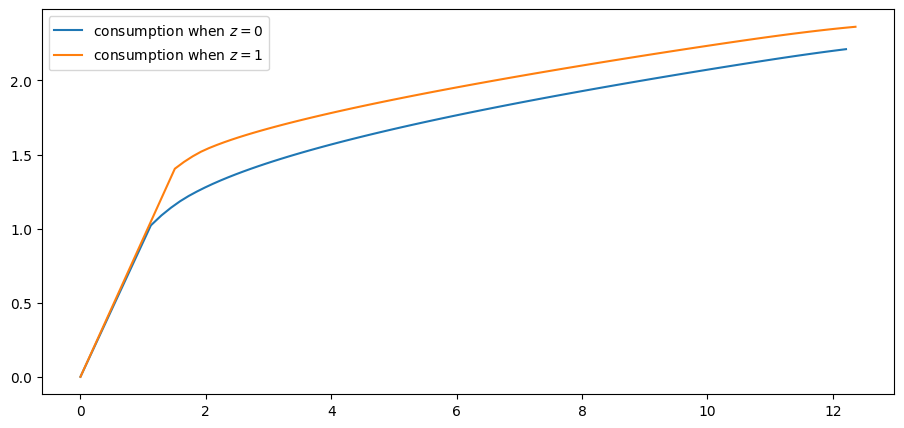

In [10]:
fig, ax = plt.subplots()
for z in range(len(ifp.P)):
    ax.plot(a_star[:, z], sigma_star[:, z], label=f"consumption when $z={z}$")

plt.legend()
plt.show()

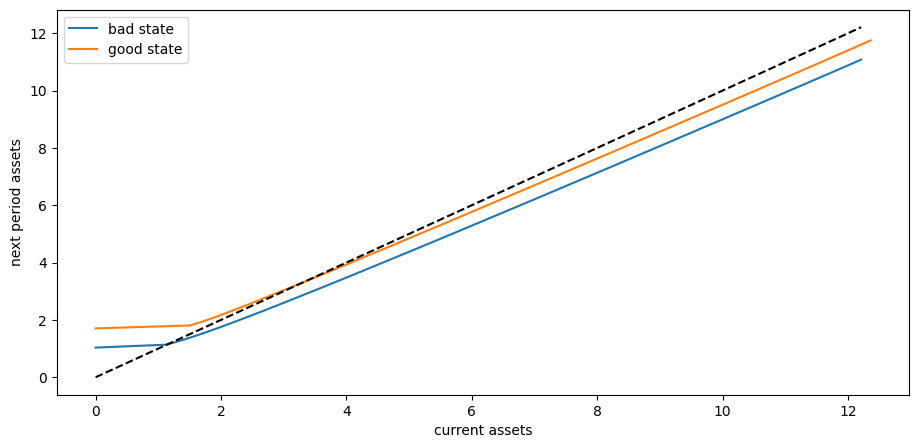

In [11]:
Y_mean = [np.mean(ifp.Y(z, ifp.eta_draws)) for z in (0, 1)]
R_mean = np.mean(ifp.R(z, ifp.zeta_draws))

a = a_star
fig, ax = plt.subplots()
for z, lb in zip((0, 1), ("bad state", "good state")):
    ax.plot(a[:, z], R_mean * (a[:, z] - sigma_star[:, z]) + Y_mean[z], label=lb)

ax.plot(a[:, 0], a[:, 0], "k--")
ax.set(xlabel="current assets", ylabel="next period assets")

ax.legend()
plt.show()